# Modèles de Machine Learning sur 2 classes (saine/malade) pour les images de New Plant Disease

## 0 Importation des bibliothèques nécessaires

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split
import joblib
import os

## 1 Préparation des données

### 1.1 Installation du Drive

In [2]:
#Pour Google Colab, installation du drive
#Installation du drive
from google.colab import drive
drive.mount('/content/drive')
#Attention, attendre que le Drive soit réellement monté avant de poursuivre

Mounted at /content/drive


### 1.2 Répertoire de sauvegarde des modèles

In [20]:
# Pour une utilisation sous Google Drive
# Vérification de la présence du répertoire de sauvegarde des modèles
pathRep_mod = "/content/drive/MyDrive/ProjetPlantes/Donnees/modeles"
os.makedirs(pathRep_mod, exist_ok=True)

### 1.3 Création du dataFrame à partir du fichier df_HistInt_NPD.csv

In [5]:
#Chemin du fichier df_HistInt_NPD.csv
ficHistInt_csv = "/content/drive/MyDrive/ProjetPlantes/Donnees/df_HistInt_NPD.csv"
dtype = {'Suffixe': str,'Luminosite': str}
df_HistInt_NPD = pd.read_csv(ficHistInt_csv, dtype=dtype)
df_HistInt_NPD.head()

,Categorie,Plante,Maladie,Saine,Set,Suffixe,Luminosite,0,1,2,...,698,699,700,701,702,703,704,705,706,707
0,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,75.0,93.0,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,8.0,18.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,1013.0,1174.0,1255.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,NaN,0,3.0,5.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#La colonne Suffixe a des NaN. On remplace ceux-ci par ""
df_HistInt_NPD["Suffixe"] = df_HistInt_NPD["Suffixe"].fillna("")
df_HistInt_NPD["Suffixe"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 87863 entries, 0 to 87862
Series name: Suffixe
Non-Null Count  Dtype 
--------------  ----- 
87863 non-null  object
dtypes: object(1)
memory usage: 686.6+ KB


In [8]:
df_HistInt_NPD.head()

,Categorie,Plante,Maladie,Saine,Set,Suffixe,Luminosite,0,1,2,...,698,699,700,701,702,703,704,705,706,707
0,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,75.0,93.0,80.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,8.0,18.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,1013.0,1174.0,1255.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,,0,3.0,5.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Cherry_(including_sour)__Powdery_mildew,Cherry_(including_sour),Powdery_mildew,0,valid,fliplr.jpg,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.4 Sélection des données

In [9]:
#Afin de comparer avec le modèle de PlantVillage, on va sélectionner les données de NPD qui viennent directement de
#PlantDisease sans transformation, c'est à dire les images qui n'ont pas eu de suffixe
#De plus une image avec rotation ou symétrie aura le même diagramme d'intensité que son image d'origine, il n'y a donc
#pas d'intérêt de sélectionner les images avec suffixe

#Création de deux dataFrames distinsts, un pour chaque environnement (train et valid)
df_Select_train = df_HistInt_NPD[(df_HistInt_NPD['Suffixe'] == "") & (df_HistInt_NPD['Set'] == "train")]
df_Select_valid = df_HistInt_NPD[(df_HistInt_NPD['Suffixe'] == "") & (df_HistInt_NPD['Set'] == "valid")]

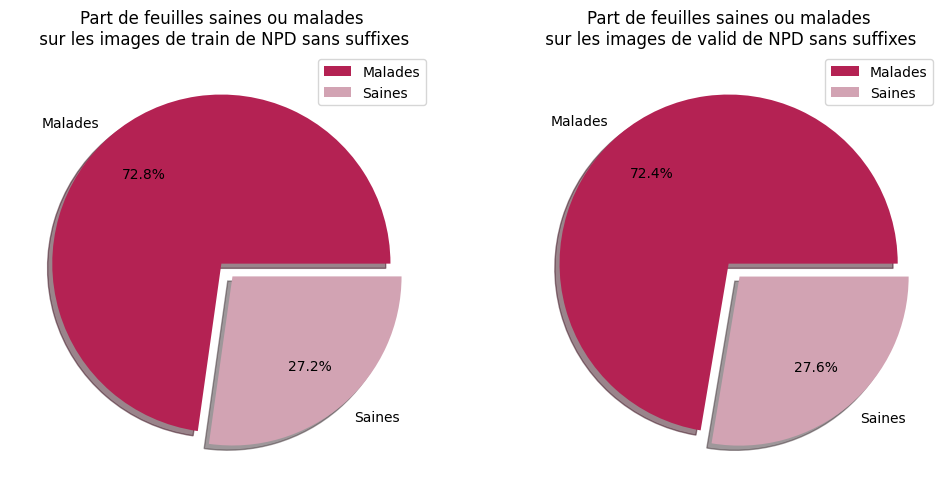

In [10]:
#répartition des feuilles saines/malades pour les images sans suffixe dans chaque jeu de données train et valid
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12))

plt.subplot(121)
plt.pie(x=df_Select_train['Saine'].value_counts(),
        labels=['Malades', 'Saines'],
        colors=['#b42253','#d2a3b3'],
        explode=[0, 0.1],
        autopct='%1.1f%%',
        pctdistance=0.7,
        labeldistance=1.1,
        shadow=True)
plt.title("Part de feuilles saines ou malades\n sur les images de train de NPD sans suffixes")
plt.legend();

plt.subplot(122)
plt.pie(x=df_Select_valid['Saine'].value_counts(),
        labels=['Malades', 'Saines'],
        colors=['#b42253','#d2a3b3'],
        explode=[0, 0.1],
        autopct='%1.1f%%',
        pctdistance=0.7,
        labeldistance=1.1,
        shadow=True)

plt.title("Part de feuilles saines ou malades\n sur les images de valid de NPD sans suffixes")
plt.legend();

In [11]:
#Préparation des tables target et data pour équilibrer les nombres de feuilles entre saines/malades pour chaque jeu de données
target_train = df_Select_train['Saine']
target_valid = df_Select_valid['Saine']
#suppression de toutes les colonnes autres que celles des histogrammes d'intensité
colonnes = ['Categorie','Plante','Maladie','Saine','Set','Suffixe','Luminosite']
data_train = df_Select_train.drop(colonnes,axis=1)
data_valid = df_Select_valid.drop(colonnes,axis=1)

### 1.5 Undersampling des données

In [12]:
#Les classes ne sont pas équilibrées, on va faire de l'undersampling
rus = RandomUnderSampler()

In [13]:
#Undersampling des données de train
X_train, y_train = rus.fit_resample(data_train,target_train)
#Nb d'éléments par classe pour train
y_train.value_counts()

0    9987
1    9987
Name: Saine, dtype: int64

In [14]:
#Undersampling des données de valid
X_test, y_test = rus.fit_resample(data_valid,target_valid)
#Nb d'éléments par classe pour valid
y_test.value_counts()

0    2531
1    2531
Name: Saine, dtype: int64

## 2 Classification
### 2.1 Modèle de classification Random Forest

In [15]:
#Modèle de classification Random Forest
modelRF = RandomForestClassifier(n_jobs = -1)
# Entraînement
modelRF.fit(X_train,y_train)
# Prédiction
test_pred_RF = modelRF.predict(X_test)
score_RF = accuracy_score(y_test,test_pred_RF)
print("Le score de précision est : ",score_RF*100, "%")


Le score de précision est :  91.68312919794548 %


In [ ]:
# Compte-rendu évaluatif détaillé de la classification Random Forest
print("compte rendu évaluatif détaillé de la classification Random Forest \n", classification_report(y_test,test_pred_RF))
# matrice de confusion
pd.crosstab(y_test, test_pred_RF, rownames=['Classe réelle'], colnames=['Classe prédite'])

compte rendu évaluatif détaillé de la classification Random Forest 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      2531
           1       0.92      0.92      0.92      2531

    accuracy                           0.92      5062
   macro avg       0.92      0.92      0.92      5062
weighted avg       0.92      0.92      0.92      5062



Classe prédite,0,1
Classe réelle,,
0,2334,197
1,214,2317


In [21]:
# Sauvegarde du modèle dans un fichier
nomFicModele = pathRep_mod + '/modelRF_2.pkl'
joblib.dump(modelRF, nomFicModele)

['/content/drive/MyDrive/ProjetPlantes/Donnees/modeles/modelRF_2.pkl']

### 2.2 Modèle de classification par régression logistique

In [ ]:
#Modèle de classification régression logistique
modelLR = LogisticRegression(C=1.0,max_iter=2000,solver='liblinear')
# Entraînement
modelLR.fit(X_train,y_train)
# Prédiction
test_pred_LR = modelLR.predict(X_test)
score_LR = accuracy_score(y_test,test_pred_LR)
print("Le score de précision est : ",score_LR*100, "%")

Le score de précision est :  81.37099960489925 %


In [ ]:
# Compte-rendu évaluatif détaillé de la classification par régression logistique
print("compte rendu évaluatif détaillé de la classification par régression logistique \n", classification_report(y_test,test_pred_LR))
# matrice de confusion
pd.crosstab(y_test, test_pred_LR, rownames=['Classe réelle'], colnames=['Classe prédite'])

compte rendu évaluatif détaillé de la classification par régression logistique 
               precision    recall  f1-score   support

           0       0.81      0.82      0.81      2531
           1       0.82      0.81      0.81      2531

    accuracy                           0.81      5062
   macro avg       0.81      0.81      0.81      5062
weighted avg       0.81      0.81      0.81      5062



Classe prédite,0,1
Classe réelle,,
0,2067,464
1,479,2052


### 2.3 Modèle de classification par SVM

In [23]:
#Modèle de classification SVM
modelSVM = SVC(gamma=0.01, kernel = 'poly')
# Entraînement
modelSVM.fit(X_train,y_train)
# Prédiction
test_pred_SVM = modelSVM.predict(X_test)
score_SVM = accuracy_score(y_test,test_pred_SVM)
print("Le score de précision est : ",score_SVM*100, "%")

Le score de précision est :  90.14223627024892 %


In [ ]:
# Compte-rendu évaluatif détaillé de la classification SVM
print("compte rendu évaluatif détaillé de la classification SVM \n", classification_report(y_test,test_pred_SVM))
# matrice de confusion
pd.crosstab(y_test, test_pred_SVM, rownames=['Classe réelle'], colnames=['Classe prédite'])

compte rendu évaluatif détaillé de la classification SVM 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      2531
           1       0.92      0.89      0.91      2531

    accuracy                           0.91      5062
   macro avg       0.91      0.91      0.91      5062
weighted avg       0.91      0.91      0.91      5062



Classe prédite,0,1
Classe réelle,,
0,2335,196
1,273,2258


In [24]:
# Sauvegarde du modèle dans un fichier
nomFicModele = pathRep_mod + '/modelSVM_2.pkl'
joblib.dump(modelSVM, nomFicModele)

['/content/drive/MyDrive/ProjetPlantes/Donnees/modeles/modelSVM_2.pkl']

### 2.4 Modèle de classification par XGBoots

In [ ]:
#Séparation des données de test en 2 parties
X_test2, X_valid, y_test2, y_valid = train_test_split(X_test, y_test, test_size = 0.5)
#Création des objets DMAtrix
train = xgb.DMatrix(data=X_train,label=y_train)
test = xgb.DMatrix(data=X_test2,label=y_test2)
valid = xgb.DMatrix(data=X_valid,label=y_valid)

In [ ]:
paramsXGB = {'booster' : 'gbtree', 'learning_rate' : 0.01, 'objective' : 'binary:logistic'}
modelXGB = xgb.train(params = paramsXGB, dtrain = train, num_boost_round = 500, early_stopping_rounds= 15, evals= [(train, 'train'), (test, 'eval')])

[0]	train-logloss:0.68772	eval-logloss:0.68799
[1]	train-logloss:0.68238	eval-logloss:0.68286
[2]	train-logloss:0.67717	eval-logloss:0.67792
[3]	train-logloss:0.67203	eval-logloss:0.67307
[4]	train-logloss:0.66702	eval-logloss:0.66837
[5]	train-logloss:0.66205	eval-logloss:0.66363
[6]	train-logloss:0.65722	eval-logloss:0.65911
[7]	train-logloss:0.65246	eval-logloss:0.65459
[8]	train-logloss:0.64775	eval-logloss:0.65018
[9]	train-logloss:0.64315	eval-logloss:0.64593
[10]	train-logloss:0.63856	eval-logloss:0.64164
[11]	train-logloss:0.63407	eval-logloss:0.63746
[12]	train-logloss:0.62968	eval-logloss:0.63338
[13]	train-logloss:0.62529	eval-logloss:0.62931
[14]	train-logloss:0.62100	eval-logloss:0.62534
[15]	train-logloss:0.61681	eval-logloss:0.62146
[16]	train-logloss:0.61266	eval-logloss:0.61759
[17]	train-logloss:0.60863	eval-logloss:0.61386
[18]	train-logloss:0.60455	eval-logloss:0.61013
[19]	train-logloss:0.60060	eval-logloss:0.60649
[20]	train-logloss:0.59667	eval-logloss:0.60291
[2

In [ ]:
#Stocke dans preds les probabilités obtenues avec xgb2 sur valid
preds = modelXGB.predict(valid)
#Crée une Series contenant les labels correspondant aux probabilités obtenues, en utilisant un seuil de 0.5
valid_pred_XGB = pd.Series(np.where(preds > 0.5, 1, 0))

score_XGB = accuracy_score(y_valid, valid_pred_XGB)
print("Le score de précision est : ",score_XGB*100, "%")
# Compte-rendu évaluatif détaillé de la classification XGBoost
print("compte rendu évaluatif détaillé de la classification XGBoost \n", classification_report(y_valid, valid_pred_XGB))
#Affiche une matrice de confusion
confusion_matrix(y_valid, valid_pred_XGB)

Le score de précision est :  90.83366258395891 %
compte rendu évaluatif détaillé de la classification XGBoost 
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      1261
           1       0.92      0.90      0.91      1270

    accuracy                           0.91      2531
   macro avg       0.91      0.91      0.91      2531
weighted avg       0.91      0.91      0.91      2531



array([[1156,  105],
       [ 127, 1143]])